In [197]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
# nlp = en_core_web_sm.load()
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import SMOTE


import xgboost as xgb
from xgboost import XGBClassifier

from nltk.tokenize import word_tokenize
from collections import Counter
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics.pairwise import pairwise_distances

from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kous5\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kous5\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [198]:
pd.set_option('display.max_columns', 70)
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_colwidth', 400)
pd.set_option("display.precision", 2)

# Data Loading

In [199]:
df = pd.read_csv("data_source/sample30.csv")

# EDA

In [200]:
df.head(5)

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                                                                                                                                       categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap   
1                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
2                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
3                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   
4                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   
3                                 K-Y   
4                                 K-Y   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)  2012-11-30T06:21:45.000Z   
1  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
2  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
3            K-Y Love Sensuality Pleasure Gel  2016-01-06T00:00:00.000Z   
4            K-Y Love Sensuality Pleasure Gel  2016-12-21T00:00:00.000Z   

  reviews_didPurchase reviews_doRecommend  reviews_rating  \
0                 NaN                 NaN               5   
1                True                 NaN               5   
2                True                 NaN               5   
3               False               False               1   
4               False               False               1   

                                                                                                                                                                                                                                                                                                                                                                                                      reviews_text  \
0                                                                                                                                                                                                        i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.   
1                                                                                                                                                                                                                                                                                                                                                   Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                                                                                                                                                                                                                     Good flavor.   
3  I read through the reviews on here before looking in to buying one of the

In [201]:
df.shape

(30000, 15)

In [202]:
#checking dataframe columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

### Checking for Null values

In [203]:
# Getting NULL values and percentage of the columns
count_for_null = df[df.columns[df.isna().any()]].isna().sum().sort_values(ascending=False)
percentage_of_null = (df[df.columns[df.isna().any()]].isna().sum() * 100 / df.shape[0]).sort_values(ascending=False)
check_data = pd.concat([count_for_null, percentage_of_null], axis=1, keys=['Count', 'Percentage'])
check_data

Count  Percentage
reviews_userProvince  29830    9.94e+01
reviews_userCity      28071    9.36e+01
reviews_didPurchase   14068    4.69e+01
reviews_doRecommend    2570    8.57e+00
reviews_title           190    6.33e-01
manufacturer            141    4.70e-01
reviews_username         63    2.10e-01
reviews_date             46    1.53e-01
user_sentiment            1    3.33e-03

### Removing columns from the dataset where null % is more than 50

In [204]:
#have a copy to work on
df_copy = df.copy()

In [205]:
df_copy.drop(columns=['reviews_userCity', 'reviews_userProvince','reviews_didPurchase'], inplace=True)

In [206]:
df_copy.shape

(30000, 12)

In [207]:
# Checking NULLs again
count_for_null = df_copy[df_copy.columns[df_copy.isna().any()]].isna().sum().sort_values(ascending=False)
percentage_of_null = (df_copy[df_copy.columns[df_copy.isna().any()]].isna().sum() * 100 / df_copy.shape[0]).sort_values(ascending=False)
check_data = pd.concat([count_for_null, percentage_of_null], axis=1, keys=['Count', 'Percentage'])
check_data

Count  Percentage
reviews_doRecommend   2570    8.57e+00
reviews_title          190    6.33e-01
manufacturer           141    4.70e-01
reviews_username        63    2.10e-01
reviews_date            46    1.53e-01
user_sentiment           1    3.33e-03

### Checking  column


In [208]:
df_copy.reviews_doRecommend.value_counts(normalize=False)

True     25880
False     1550
Name: reviews_doRecommend, dtype: int64

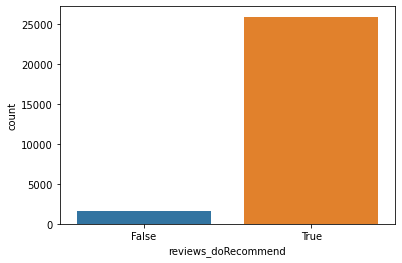

In [209]:
sns.countplot(x = 'reviews_doRecommend', data = df_copy)
plt.show()

In [210]:
#drop reviews_doRecommend as the variety of data in this column is least
df_copy.drop(columns=['reviews_doRecommend'], inplace=True)

In [211]:
# Checking NULLs again
count_for_null = df_copy[df_copy.columns[df_copy.isna().any()]].isna().sum().sort_values(ascending=False)
percentage_of_null = (df_copy[df_copy.columns[df_copy.isna().any()]].isna().sum() * 100 / df_copy.shape[0]).sort_values(ascending=False)
check_data = pd.concat([count_for_null, percentage_of_null], axis=1, keys=['Count', 'Percentage'])
check_data

Count  Percentage
reviews_title       190    6.33e-01
manufacturer        141    4.70e-01
reviews_username     63    2.10e-01
reviews_date         46    1.53e-01
user_sentiment        1    3.33e-03

### NULL values check

In [212]:
# Checking rowcount before deletion
df_copy.shape

(30000, 11)

In [213]:
df_copy = df_copy[~ df_copy.reviews_title.isna() ]

In [214]:
# Checking rowcount post deletion
df_copy.shape

(29810, 11)

In [215]:
# Checking NULLs again
count_for_null = df_copy[df_copy.columns[df_copy.isna().any()]].isna().sum().sort_values(ascending=False)
percentage_of_null = (df_copy[df_copy.columns[df_copy.isna().any()]].isna().sum() * 100 / df_copy.shape[0]).sort_values(ascending=False)
check_data = pd.concat([count_for_null, percentage_of_null], axis=1, keys=['Count', 'Percentage'])
check_data

Count  Percentage
manufacturer        141    4.73e-01
reviews_username     62    2.08e-01
reviews_date         46    1.54e-01
user_sentiment        1    3.35e-03

In [216]:
# Checking rowcount before deletion
df_copy.shape

(29810, 11)

In [217]:
df_copy = df_copy[~ df_copy.reviews_username.isna() ]

In [218]:
# Checking rowcount post deletion
df_copy.shape

(29748, 11)

In [219]:
# Checking NULLs again
count_for_null = df_copy[df_copy.columns[df_copy.isna().any()]].isna().sum().sort_values(ascending=False)
percentage_of_null = (df_copy[df_copy.columns[df_copy.isna().any()]].isna().sum() * 100 / df_copy.shape[0]).sort_values(ascending=False)
check_data = pd.concat([count_for_null, percentage_of_null], axis=1, keys=['Count', 'Percentage'])
check_data

Count  Percentage
manufacturer      141    4.74e-01
reviews_date       40    1.34e-01
user_sentiment      1    3.36e-03

In [220]:
df_copy.user_sentiment.value_counts()

Positive    26412
Negative     3335
Name: user_sentiment, dtype: int64

In [221]:
df_copy[ df_copy.user_sentiment.isna() ]

id   brand  \
28354  AVpfRTh1ilAPnD_xYic2  Disney   

                                                                                                                                                                                                                                            categories  \
28354  Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys   

      manufacturer  \
28354  Walt Disney   

                                                                      name  \
28354  Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)   

                   reviews_date  reviews_rating  \
28354  2014-11-07T00:00:00.000Z               5   

                                                                                                                                                                                                                                                                                                                                                                            reviews_text  \
28354  my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy   

                                         reviews_title reviews_username  \
28354  a super hit with my children. they loved it!!??         7.87E+11   

      user_sentiment  
28354            NaN

In [222]:
df_copy[ df_copy.user_sentiment.isna() ].user_sentiment

28354    NaN
Name: user_sentiment, dtype: object

In [223]:
df_copy.user_sentiment.fillna('Positive', inplace=True)

In [224]:
# Checking NULLs again
count_for_null = df_copy[df_copy.columns[df_copy.isna().any()]].isna().sum().sort_values(ascending=False)
percentage_of_null = (df_copy[df_copy.columns[df_copy.isna().any()]].isna().sum() * 100 / df_copy.shape[0]).sort_values(ascending=False)
check_data = pd.concat([count_for_null, percentage_of_null], axis=1, keys=['Count', 'Percentage'])
check_data

Count  Percentage
manufacturer    141        0.47
reviews_date     40        0.13

In [225]:
df_copy.head()

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                                                                                                                                       categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap   
1                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
2                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
3                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   
4                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   
3                                 K-Y   
4                                 K-Y   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)  2012-11-30T06:21:45.000Z   
1  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
2  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
3            K-Y Love Sensuality Pleasure Gel  2016-01-06T00:00:00.000Z   
4            K-Y Love Sensuality Pleasure Gel  2016-12-21T00:00:00.000Z   

   reviews_rating  \
0               5   
1               5   
2               5   
3               1   
4               1   

                                                                                                                                                                                                                                                                                                                                                                                                      reviews_text  \
0                                                                                                                                                                                                        i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.   
1                                                                                                                                                                                                                                                                                                                                                   Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                                                                                                                                                                                                                     Good flavor.   
3  I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, 

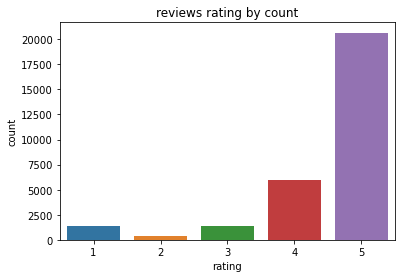

In [226]:
sns.countplot(x = 'reviews_rating', data = df_copy).set(title="reviews rating by count", xlabel="rating", ylabel="count")
plt.show()

### Checking for negative reviews

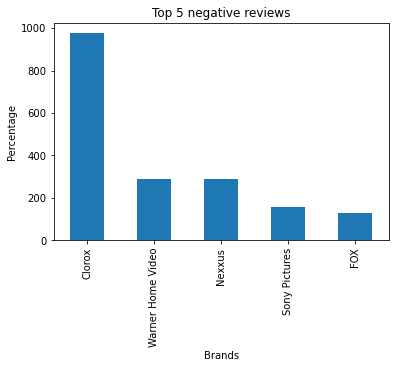

In [227]:
df_copy[ df_copy.user_sentiment == 'Negative' ].brand.value_counts(normalize=False, ascending=False).head(5).plot(kind='bar')
plt.title("Top 5 negative reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage")
plt.show()

### Checking positive reviews

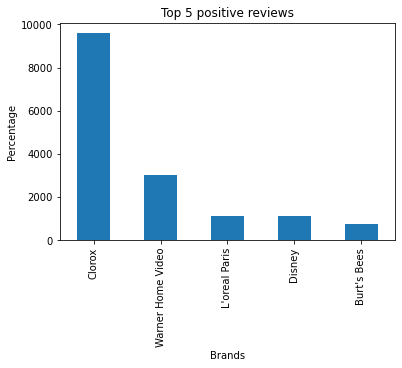

In [228]:
df_copy[ df_copy.user_sentiment == 'Positive' ].brand.value_counts(normalize=False, ascending=False).head(5).plot(kind='bar')
plt.title("Top 5 positive reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage")
plt.show()

### Checking review counts based on year

In [229]:
# Before type conversion
df_copy.reviews_date.dtype

dtype('O')

In [230]:
df_copy['date'] = pd.to_datetime(df_copy['reviews_date'], errors='coerce')

In [231]:
# After type conversion
df_copy.date.dtype

datetime64[ns, UTC]

In [232]:
# Getting year component from date
df_copy.date.dt.year

0        2012.0
1        2017.0
2        2017.0
3        2016.0
4        2016.0
          ...  
29995    2017.0
29996    2017.0
29997    2017.0
29998    2017.0
29999    2017.0
Name: date, Length: 29748, dtype: float64

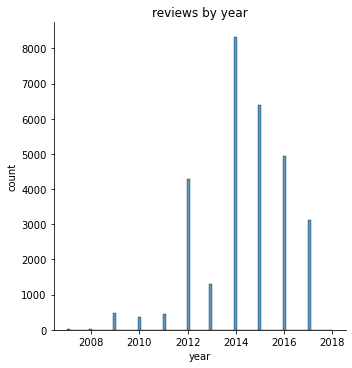

In [233]:
# Creating a distribution plot based on reviews year 
sns.displot(data=df_copy, x=df_copy.date.dt.year).set(title="reviews by year", xlabel="year", ylabel="count")
plt.show()

### Checking Movie Rating

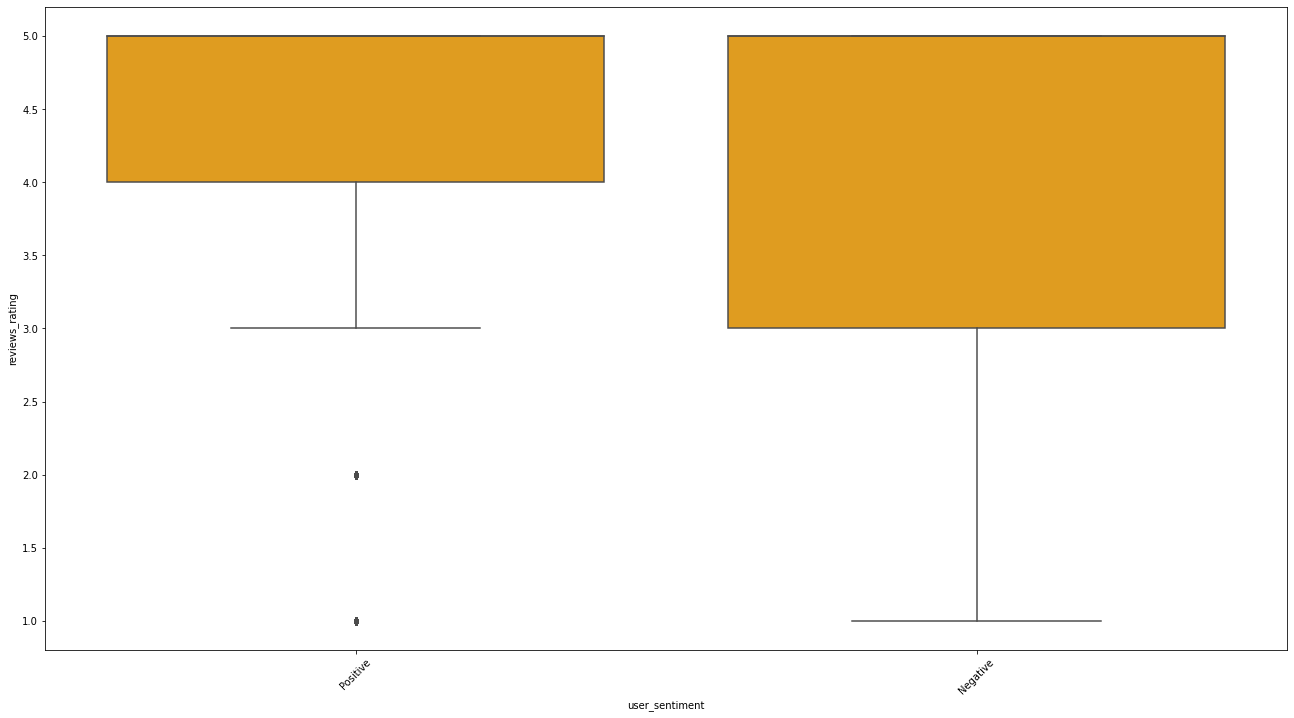

In [234]:
plt.figure(figsize = [20,12])

sns.boxplot(data=df_copy, x='user_sentiment', y='reviews_rating', color='orange')
plt.xticks(rotation = 45)

plt.tight_layout(pad = 8)
plt.show()

In [235]:
df_copy[ (df_copy.user_sentiment == 'Negative') & (df_copy.reviews_rating >= 4) ].groupby(['reviews_rating']).count().user_sentiment

reviews_rating
4     548
5    1848
Name: user_sentiment, dtype: int64

# Conversion

In [236]:
# Convert all the text columns to string

df_copy['reviews_title'] = df_copy['reviews_title'].astype(str)
df_copy['reviews_text'] = df_copy['reviews_text'].astype(str)
df_copy['reviews_username'] = df_copy['reviews_username'].astype(str)
df_copy['brand'] = df_copy['brand'].astype(str)
df_copy['manufacturer'] = df_copy['manufacturer'].astype(str)
df_copy['name'] = df_copy['name'].astype(str)
df_copy['categories'] = df_copy['categories'].astype(str)

# Pre-Processing

In [237]:
# Getting a copy of dataframe for pre-processing
df_new = df_copy.copy()

## Combining columns

In [238]:
df_new['all_reviews'] = df_new['reviews_text'] + " " + df_new['reviews_title']
df_new.drop(columns=['reviews_text', 'reviews_title'], inplace=True)

In [239]:
df_new.shape

(29748, 11)

## Removing extra columns

In [240]:
df_new.drop(columns=['categories', 'date', 'manufacturer'], inplace=True)

## Creating new dataframe

In [241]:
df_sent_analysis = df_new[['id','name', 'user_sentiment', 'all_reviews']]

In [242]:
df_sent_analysis.shape

(29748, 4)

## Handling punctuations

In [243]:
# removing punctuations
def punctuation_removal(sentence):
    sentence = sentence.lower()
    regex_pattern = '[^\w\s]'
    sentence = re.sub(regex_pattern, '', sentence)
    return sentence

In [244]:
df_sent_analysis['review_nopunctuation'] = df_sent_analysis['all_reviews'].apply(punctuation_removal)

## Stopwords removal

In [245]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kous5\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [246]:
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words("english"))
print(stopwords_set)

{'such', 'my', 'once', 'at', 'y', 'being', "wasn't", 'hers', 'we', 's', 'down', 'as', 'been', 'she', 'having', "couldn't", 'below', 'own', "you'd", 'these', 'does', 'up', "don't", 'but', 'again', 'shouldn', "should've", 'his', 'any', "you're", "that'll", 'off', 'm', 'under', 'and', 'the', 'from', 'by', 'this', "you'll", 'until', 'on', 'mustn', 'what', 'd', 'few', "weren't", 'it', 'mightn', 'didn', "needn't", 'her', 'yourselves', 'to', "didn't", 'not', 'ma', 'some', 'over', 'when', 'isn', 'after', "isn't", 'ain', 'theirs', 'has', 'both', 'nor', 'shan', 'i', 'your', 'weren', 'can', "mustn't", 'itself', 'because', 'or', 'here', 'am', 'them', 'which', 'couldn', 'now', 'had', 'there', 'just', "hasn't", "won't", 'needn', 're', "mightn't", 'themselves', 'most', 'than', "hadn't", 'should', 'wasn', 't', 'o', 'do', 'was', 'a', 'with', 'me', 'you', 'wouldn', 'who', 'each', 'have', 'above', 'how', 'll', "aren't", 'during', 'doesn', 'hadn', 'no', 'of', 'will', "wouldn't", 'were', "haven't", 'they',

In [247]:
# removing stopwords
def stopwords_removal(sentence):
    sentence = sentence.lower()
    words = word_tokenize(sentence)
    text_nostopwords = " ".join( [word for word in words if word not in stopwords_set] )
    return sentence

In [248]:
df_sent_analysis['review_nopunctuation'] = df_sent_analysis['review_nopunctuation'].apply(stopwords_removal)

## Lemmatization

In [249]:
#Lemmatize the text
def lemma_removal(input_text):
    sent = []
    doc = nlp(input_text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [250]:
df_sent_analysis['lemmatized_reviews'] = df_sent_analysis['review_nopunctuation'].apply(lemma_removal)

In [251]:
df_sent_analysis = df_sent_analysis[['id','name', 'user_sentiment', 'lemmatized_reviews']]

In [252]:
df_sent_analysis.shape

(29748, 4)

In [255]:
# Saving the the cleaned dataframe
pickle.dump(df_sent_analysis, open("./models/clean_data.pkl","wb"))

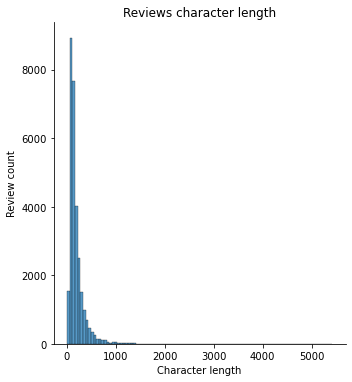

In [256]:
# Visualizing 'lemmatized_reviews' character length
char_length = [len(sentence) for sentence in df_sent_analysis['lemmatized_reviews']]

sns.displot(char_length, kind='hist', bins=100)
plt.xlabel("Character length")
plt.ylabel("Review count")
plt.title("Reviews character length")
plt.show()

## TF-IDF

In [257]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english', ngram_range=(1,2))

In [258]:
X = tfidf.fit_transform(df_sent_analysis['lemmatized_reviews'])

y= df_sent_analysis['user_sentiment']

In [259]:
# Saving the the tfidf vectorizer model
pickle.dump(tfidf, open("./models/tfidf.pkl","wb"))

## Train, test split

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [261]:
print("Train data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Train data shape: (22311, 16073) (22311,)
Test data shape: (7437, 16073) (7437,)


## Class Imbalance

In [262]:
# Check for imbalance
df_sent_analysis['user_sentiment'].value_counts(normalize=False)

Positive    26413
Negative     3335
Name: user_sentiment, dtype: int64

In [263]:
counter = Counter(y_train)
print("Without handling imbalance", counter)

# smote = SMOTE(random_state=42)

smote = SMOTE(random_state=40)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("With handling imbalance", counter)

Without handling imbalance Counter({'Positive': 19786, 'Negative': 2525})
With handling imbalance Counter({'Positive': 19786, 'Negative': 19786})


# Building the model

In [264]:
def score_calculation(classifier, X_test, y_test):

  y_pred = classifier.predict(X_test)
  conf_m = confusion_matrix(y_test, y_pred)
  print("Confusion Matrix ")
  fig, ax = plt.subplots(figsize=(6, 6))
  ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                  annot=True,
                  cbar=False,
                  cmap="RdYlGn", fmt = '0.1f')
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.show()

  # Calculating the values of True Positives, True Negatives, False Positivies and False Negatives
  TP = conf_m[1][1]
  TN = conf_m[0][0]
  FP = conf_m[0][1]
  FN = conf_m[1][0]

  print('True Positives:', TP)
  print('True Negatives:', TN)
  print('False Positives:', FP)
  print('False Negatives:', FN)
  print("\n")

  accuracy_value = accuracy_score(y_test, y_pred)
  accuracy = round(accuracy_value,2)
  
  sensitivity_score = (TP / float(TP + FN))
  sensitivity = round(sensitivity_score,2)
  
  specificity_score = (TN / float(TN + FP))
  specificity = round(specificity_score,2)  
  
  precision_score = (TN / float(TN + FP))
  precision = round(precision_score,2)  
  
  F1_score = 2 * ((precision * sensitivity) / (precision + sensitivity))
  F1_score = round(F1_score,2)  
  
  print(f'Accuracy Score: {accuracy}')
  print(f'Sensitivity Score: {sensitivity}') 
  print(f'Specificity Score: {specificity}') 
  print(f'Precision: {precision}')
  print(f'F1 Score: {F1_score}')

  evaluation_metrics = []
  evaluation_metrics.append(accuracy)
  evaluation_metrics.append(sensitivity)
  evaluation_metrics.append(specificity)
  evaluation_metrics.append(precision)
  evaluation_metrics.append(F1_score)
  
  return evaluation_metrics

## Logistic Regression

In [265]:
regressor = LogisticRegression(random_state=42, solver='liblinear').fit(X_train_sm, y_train_sm)

Confusion Matrix 


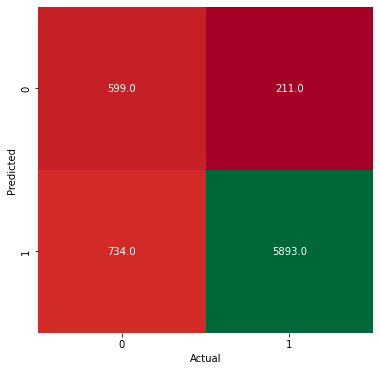

True Positives: 5893
True Negatives: 599
False Positives: 211
False Negatives: 734


Accuracy Score: 0.87
Sensitivity Score: 0.89
Specificity Score: 0.74
Precision: 0.74
F1 Score: 0.81


In [266]:
logistic_regression_metrics = score_calculation(regressor, X_test, y_test)

In [267]:
# Printing the scores of the base model as reference
df_logrermat = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity','Specificity','Precision','F1 Score'], 'Base Model': logistic_regression_metrics},
                             columns = ['Metrics', 'Base Model']
                             )
df_logrermat

Metrics  Base Model
0     Accuracy        0.87
1  Sensitivity        0.89
2  Specificity        0.74
3    Precision        0.74
4     F1 Score        0.81

### HyperParameter Tuning

In [268]:
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

In [269]:
logreg_hyperparameter_tuning = GridSearchCV(LogisticRegression(random_state=40),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

logreg_hyperparameter_tuning.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [270]:
# Checking the best parameters
logreg_hyperparameter_tuning.best_params_

{'C': 100, 'solver': 'liblinear'}

### HyperParameter Tuned Model

Confusion Matrix 


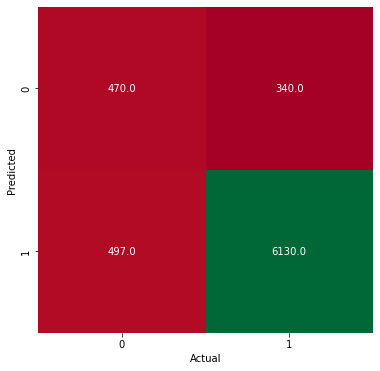

True Positives: 6130
True Negatives: 470
False Positives: 340
False Negatives: 497


Accuracy Score: 0.89
Sensitivity Score: 0.93
Specificity Score: 0.58
Precision: 0.58
F1 Score: 0.71


In [271]:
# Getting the scores of the tuned model
logreg_tuned_metrics = score_calculation(logreg_hyperparameter_tuning, X_test, y_test)

In [272]:
# Printing the scores of the base and tuned Logistic Regression model for reference
dict_logreg_basetuned_metrics = {'Metrics': ['Accuracy','Sensitivity','Specificity','Precision','F1 Score'], 
                               'LR Base Model': logistic_regression_metrics,
                               'LR Tuned Model': logreg_tuned_metrics}

df_logrrg_basetuned_metrics = pd.DataFrame(dict_logreg_basetuned_metrics, columns = ['Metrics', 'LR Base Model', 'LR Tuned Model'])
df_logrrg_basetuned_metrics

Metrics  LR Base Model  LR Tuned Model
0     Accuracy           0.87            0.89
1  Sensitivity           0.89            0.93
2  Specificity           0.74            0.58
3    Precision           0.74            0.58
4     F1 Score           0.81            0.71

In [273]:
lr_base_model = pickle.dump(regressor, open('./pickle/lr_base_model.pkl', 'wb'))

In [274]:
lr_tuned_model = pickle.dump(logreg_hyperparameter_tuning, open('./pickle/lr_tuned_model.pkl', 'wb'))

## Random Forest Classifier

In [275]:
rf = RandomForestClassifier(random_state=42).fit(X_train_sm, y_train_sm)

### Base Model

Confusion Matrix 


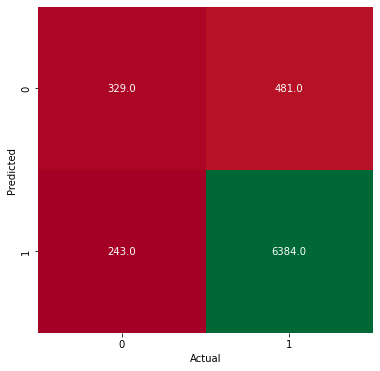

True Positives: 6384
True Negatives: 329
False Positives: 481
False Negatives: 243


Accuracy Score: 0.9
Sensitivity Score: 0.96
Specificity Score: 0.41
Precision: 0.41
F1 Score: 0.57


In [276]:
# Getting the score of the base model
randomforest_metrics = score_calculation(rf, X_test, y_test)

In [277]:
# Printing the scores of the base model as reference
df_randomforest_base_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity','Specificity','Precision','F1 Score'], 'RF Base Model': randomforest_metrics},
                             columns = ['Metrics', 'RF Base Model']
                             )
df_randomforest_base_metrics

Metrics  RF Base Model
0     Accuracy           0.90
1  Sensitivity           0.96
2  Specificity           0.41
3    Precision           0.41
4     F1 Score           0.57

### HyperParameter Tuning

In [278]:
randomforest_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": np.arange(10, 50, 5),
           "min_samples_split": np.arange(15, 500, 15),
           "min_samples_leaf": np.arange(5, 50, 5)}

In [279]:
# Setup random hyperparameter search for Random Forest Classifier
randomforest_hyperparametertune = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=randomforest_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
randomforest_hyperparametertune.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [280]:
# Check best parameters
randomforest_hyperparametertune.best_params_

{'n_estimators': 460,
 'min_samples_split': 90,
 'min_samples_leaf': 45,
 'max_depth': 30}

Confusion Matrix 


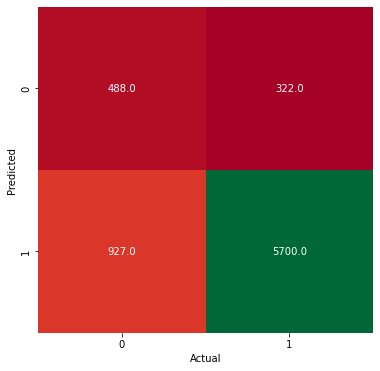

True Positives: 5700
True Negatives: 488
False Positives: 322
False Negatives: 927


Accuracy Score: 0.83
Sensitivity Score: 0.86
Specificity Score: 0.6
Precision: 0.6
F1 Score: 0.71


[0.83, 0.86, 0.6, 0.6, 0.71]

In [281]:
score_calculation(randomforest_hyperparametertune, X_test, y_test)

In [282]:
# Fine tuning using Grid Search CV
randomforest_grid = {"n_estimators": [510],
           "max_depth": [20],
           "min_samples_split": [350, 400],
           "min_samples_leaf": [45, 50]}

In [283]:
# Setup random hyperparameter search for Random Forest Classifier
randomforest_hyperparametertune = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=randomforest_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
randomforest_hyperparametertune.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


### HyperParameter tuned model

Confusion Matrix 


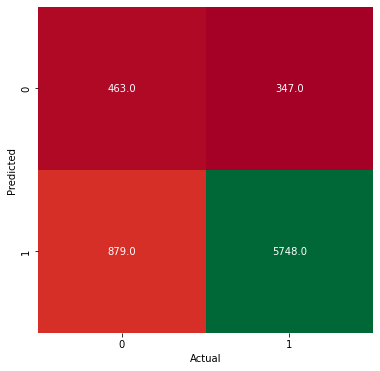

True Positives: 5748
True Negatives: 463
False Positives: 347
False Negatives: 879


Accuracy Score: 0.84
Sensitivity Score: 0.87
Specificity Score: 0.57
Precision: 0.57
F1 Score: 0.69


In [284]:
# Getting the scores of the tuned model
randomforest_tuned_metrics = score_calculation(randomforest_hyperparametertune, X_test, y_test)

In [285]:
# Printing the scores of the base and tuned Random Forest model as reference
dict_randomforest_basetuned_metrics = {'Metrics': ['Accuracy','Sensitivity','Specificity','Precision','F1 Score'], 
                               'RF Base Model': randomforest_metrics,
                               'RF Tuned Model': randomforest_tuned_metrics}

df_randomforest_basetuned_metrics = pd.DataFrame(dict_randomforest_basetuned_metrics, columns = ['Metrics', 'RF Base Model', 'RF Tuned Model'])
df_randomforest_basetuned_metrics

Metrics  RF Base Model  RF Tuned Model
0     Accuracy           0.90            0.84
1  Sensitivity           0.96            0.87
2  Specificity           0.41            0.57
3    Precision           0.41            0.57
4     F1 Score           0.57            0.69

In [286]:
rf_base_model = pickle.dump(rf, open('./pickle/rf_base_model.pkl', 'wb'))

In [287]:
rf_tuned_model = pickle.dump(randomforest_hyperparametertune, open('./pickle/rf_tuned_model.pkl', 'wb'))

## XGBoost Classifier

In [288]:
xg = xgb.XGBClassifier(random_state=42).fit(X_train_sm, y_train_sm)

[20:12:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion Matrix 


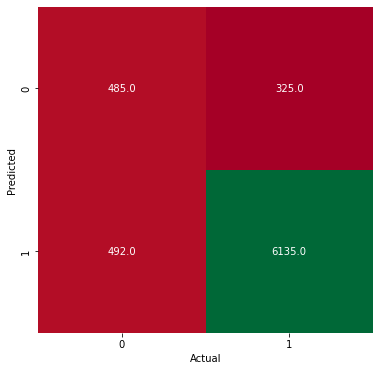

True Positives: 6135
True Negatives: 485
False Positives: 325
False Negatives: 492


Accuracy Score: 0.89
Sensitivity Score: 0.93
Specificity Score: 0.6
Precision: 0.6
F1 Score: 0.73


In [289]:
# Getting the score of the base model
xg_metrics = score_calculation(xg, X_test, y_test)

In [290]:
# Printing the scores of the base model as reference
df_xgboost_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity','Specificity','Precision','F1 Score'], 'XG Base Model': xg_metrics},
                             columns = ['Metrics', 'XG Base Model']
                             )
df_xgboost_metrics

Metrics  XG Base Model
0     Accuracy           0.89
1  Sensitivity           0.93
2  Specificity           0.60
3    Precision           0.60
4     F1 Score           0.73

### HyperParameter Tuning

In [291]:
xgboost_grid = {"learning_rate": np.arange(0.05, 1, 0.1),
           "max_depth": np.arange(5, 20, 5)
           }

In [292]:
# Setup random hyperparameter search for Random Forest Classifier
xgboost_hyperparametertune = RandomizedSearchCV(XGBClassifier(random_state=42),
                                param_distributions=xgboost_grid,
                                cv=4,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
xgboost_hyperparametertune.fit(X_train_sm, y_train_sm);

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[20:20:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [293]:
# Check best parameters
xgboost_hyperparametertune.best_params_

{'max_depth': 15, 'learning_rate': 0.15000000000000002}

Confusion Matrix 


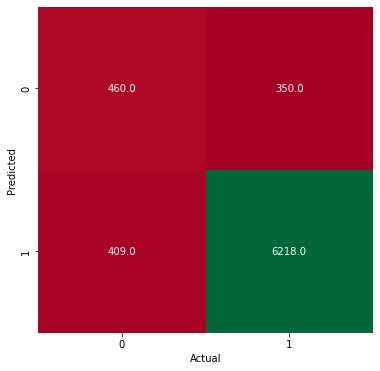

True Positives: 6218
True Negatives: 460
False Positives: 350
False Negatives: 409


Accuracy Score: 0.9
Sensitivity Score: 0.94
Specificity Score: 0.57
Precision: 0.57
F1 Score: 0.71


[0.9, 0.94, 0.57, 0.57, 0.71]

In [294]:
score_calculation(xgboost_hyperparametertune, X_test, y_test)

In [295]:
# Fine tuning with Grid Search CV
xgboost_grid = {"learning_rate": [0.45, 0.15],
           "max_depth": [5, 10]
           }

In [296]:
xgboost_hyperparametertune = GridSearchCV(XGBClassifier(random_state=42),
                                param_grid=xgboost_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

xgboost_hyperparametertune.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[20:23:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [297]:
# Check best parameters
xgboost_hyperparametertune.best_params_

{'learning_rate': 0.45, 'max_depth': 5}

### HyperParameter tuned model

Confusion Matrix 


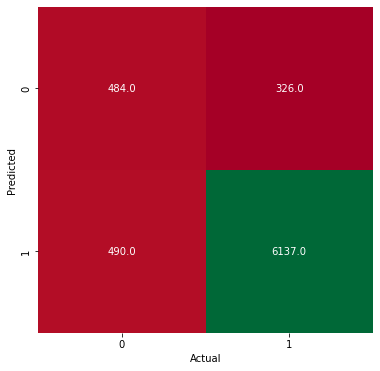

True Positives: 6137
True Negatives: 484
False Positives: 326
False Negatives: 490


Accuracy Score: 0.89
Sensitivity Score: 0.93
Specificity Score: 0.6
Precision: 0.6
F1 Score: 0.73


In [298]:
# Getting the scores of the tuned model
xgboost_tuned_metrics = score_calculation(xgboost_hyperparametertune, X_test, y_test)

In [299]:
# Printing the scores of the base and tuned XGBoost model as reference
dict_xgboost_basetuned_metrics = {'Metrics': ['Accuracy','Sensitivity','Specificity','Precision','F1 Score'], 
                               'XG Base Model': xg_metrics,
                               'XG Tuned Model': xgboost_tuned_metrics}

df_xgboost_basetuned_metrics = pd.DataFrame(dict_xgboost_basetuned_metrics, columns = ['Metrics', 'XG Base Model', 'XG Tuned Model'])
df_xgboost_basetuned_metrics

Metrics  XG Base Model  XG Tuned Model
0     Accuracy           0.89            0.89
1  Sensitivity           0.93            0.93
2  Specificity           0.60            0.60
3    Precision           0.60            0.60
4     F1 Score           0.73            0.73

In [300]:
xg_base_model = pickle.dump(xg, open('./pickle/xg_base_model.pkl', 'wb'))

In [301]:
xg_tuned_model = pickle.dump(xgboost_hyperparametertune, open('./pickle/xg_tuned_model.pkl', 'wb'))

# Model Evaluation

In [302]:
dict_basetuned_metrics = {'Metrics': ['Accuracy','Sensitivity','Specificity','Precision','F1 Score'],
                              'LR Base Model': logistic_regression_metrics, 'LR Tuned Model': logreg_tuned_metrics,
                              'RF Base Model': randomforest_metrics, 'RF Tuned Model': randomforest_tuned_metrics,
                              'XG Base Model': xg_metrics, 'XG Tuned Model': xgboost_tuned_metrics}

df_basetuned_metrics = pd.DataFrame(dict_basetuned_metrics, columns = ['Metrics', 'LR Base Model', 'LR Tuned Model', 'RF Base Model', 'RF Tuned Model', 'XG Base Model', 'XG Tuned Model'])
df_basetuned_metrics

Metrics  LR Base Model  LR Tuned Model  RF Base Model  RF Tuned Model  \
0     Accuracy           0.87            0.89           0.90            0.84   
1  Sensitivity           0.89            0.93           0.96            0.87   
2  Specificity           0.74            0.58           0.41            0.57   
3    Precision           0.74            0.58           0.41            0.57   
4     F1 Score           0.81            0.71           0.57            0.69   

   XG Base Model  XG Tuned Model  
0           0.89            0.89  
1           0.93            0.93  
2           0.60            0.60  
3           0.60            0.60  
4           0.73            0.73

In [303]:
best_sentiment_model = pickle.dump(regressor, open('./models/best_sentiment_model.pkl', 'wb'))

## Import data

In [304]:
df_recommended = pd.read_csv("data_source/sample30.csv")

In [305]:
df_recommended.shape

(30000, 15)

In [306]:
# We need only the below columns for building a recommendation system
df_recommended = df_recommended[["id", "name", "reviews_username", "reviews_rating"]]

In [307]:
df_recommended.shape

(30000, 4)

## Handling NULL values

In [308]:
# Getting total number of NULL values and percentage of the columns
count_for_null = df_recommended[df_recommended.columns[df_recommended.isna().any()]].isna().sum().sort_values(ascending=False)
percentage_of_null = (df_recommended[df_recommended.columns[df_recommended.isna().any()]].isna().sum() * 100 / df_recommended.shape[0]).sort_values(ascending=False)
check_data = pd.concat([count_for_null, percentage_of_null], axis=1, keys=['Count', 'Percentage'])
check_data

Count  Percentage
reviews_username     63        0.21

In [309]:
# Removing the rows where reviews_username is NULL
df_recommended = df_recommended[~ df_recommended.reviews_username.isna() ]

In [310]:
df_recommended.shape

(29937, 4)

In [311]:
# Check if any NULL values still exist in the dataset
count_for_null = df_recommended[df_recommended.columns[df_recommended.isna().any()]].isna().sum().sort_values(ascending=False)
percentage_of_null = (df_recommended[df_recommended.columns[df_recommended.isna().any()]].isna().sum() * 100 / df_recommended.shape[0]).sort_values(ascending=False)
check_data = pd.concat([count_for_null, percentage_of_null], axis=1, keys=['Count', 'Percentage'])
check_data

Empty DataFrame
Columns: [Count, Percentage]
Index: []

## Train, Test Split

In [312]:
train, test = train_test_split(df_recommended, test_size=0.30, random_state=42)

In [313]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

In [314]:
train_dummy = train.copy()

In [315]:
train_dummy['reviews_rating'] = train_dummy['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [316]:
train_dummy = train_dummy.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

train_dummy.head(3)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV1YnUMYglJLPUi8IJpK  AV1Ynb3bglJLPUi8IJxJ  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV1YneDPglJLPUi8IJyQ  AV1YpiJvvKc47QAVguxy  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV1YqAaMGV-KLJ3adiDj  AV1Ys0kTvKc47QAVgx1C  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV1YtGjdglJLPUi8IOfJ  AV1ZSp2uglJLPUi8IQFy  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV1ZT7GLglJLPUi8IQLI  AV1ZVIgy-jtxr-f31W9N  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV1d76w7vKc47QAVhCqn  AV1h6Gu0glJLPUi8IjA_  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV1h6gSl-jtxr-f31p40  AV1l8zRZvKc47QAVhnAv  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV2AvGnjGV-KLJ3alTQH  AV2Avn5dGV-KLJ3alTjq  \
reviews_username                                               
00sab00             

In [317]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)

In [318]:
df_pivot[~df_pivot['AV13O1A8GV-KLJ3akUyj'].isna()]

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
joshua                             5.0                   NaN   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AV1YnUMYglJLPUi8IJpK  AV1Ynb3bglJLPUi8IJxJ  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AV1YneDPglJLPUi8IJyQ  AV1YpiJvvKc47QAVguxy  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AV1YqAaMGV-KLJ3adiDj  AV1Ys0kTvKc47QAVgx1C  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AV1YtGjdglJLPUi8IOfJ  AV1ZSp2uglJLPUi8IQFy  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AV1ZT7GLglJLPUi8IQLI  AV1ZVIgy-jtxr-f31W9N  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AV1d76w7vKc47QAVhCqn  AV1h6Gu0glJLPUi8IjA_  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AV1h6gSl-jtxr-f31p40  AV1l8zRZvKc47QAVhnAv  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AV2AvGnjGV-KLJ3alTQH  AV2Avn5dGV-KLJ3alTjq  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AVpe-M4-ilAPnD_xSF1K  AVpe-MCY1cnluZ0-bCv_  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AVpe-PJnLJeJML43ziaj  AVpe-YAL1cnluZ0-bHGh  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AVpe-ltS1cnluZ0-bL8w  AVpe31o71cnluZ0-YrSD  \
reviews_username                                               
joshua                             NaN                   3.0   

id                AVpe38Uy1cnluZ0-YuJR  AVpe3_ikilAPnD_xPykq  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AVpe41TqilAPnD_xQH3d  ...  AVpfjauJLJeJML43_TKe  \
reviews_username                        ...                         
joshua                             NaN  ...                   NaN   

id                AVpfk4y7ilAPnD_xeTgd  AVpfkIiYilAPnD_xeEjr  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AVpfkQkcLJeJML43_kEC  AVpfkak01cnluZ0-nJj6  \
reviews_username                                               
joshua                             NaN                   NaN   

id                AVpfksililAPnD_xePx_  AVpfl6baLJeJML43AEQq  \
reviews_username                                             

### Normalising the rating of the product for each user around 0 mean

In [319]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [320]:
df_subtracted.head()

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AV1YnUMYglJLPUi8IJpK  AV1Ynb3bglJLPUi8IJxJ  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AV1YneDPglJLPUi8IJyQ  AV1YpiJvvKc47QAVguxy  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AV1YqAaMGV-KLJ3adiDj  AV1Ys0kTvKc47QAVgx1C  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AV1YtGjdglJLPUi8IOfJ  AV1ZSp2uglJLPUi8IQFy  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                

### Finding cosine similarity

In [321]:
user_corr = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_corr[np.isnan(user_corr)] = 0
print(user_corr)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [322]:
user_corr.shape

(18275, 18275)

## Prediction - User User

In [323]:
user_corr[user_corr<0]=0
user_corr

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [324]:
user_predicted_ratings = np.dot(user_corr, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 2.5       , ..., 1.46525748, 1.88982237,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [325]:
user_predicted_ratings.shape

(18275, 256)

In [326]:
user_final_rating = np.multiply(user_predicted_ratings,train_dummy)
user_final_rating.head()

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            2.5                   3.6   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
00sab00                           2.58                  1.02   
01impala                          0.00                  0.00   
02dakota                          0.00                  0.00   
02deuce                           0.00                  0.00   
0325home                          0.00                  0.00   

id                AV1YnUMYglJLPUi8IJpK  AV1Ynb3bglJLPUi8IJxJ  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1YneDPglJLPUi8IJyQ  AV1YpiJvvKc47QAVguxy  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1YqAaMGV-KLJ3adiDj  AV1Ys0kTvKc47QAVgx1C  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1YtGjdglJLPUi8IOfJ  AV1ZSp2uglJLPUi8IQFy  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                

## Finding the Top 20 products that a user is most likely to purchase based on the ratings

In [327]:
# Take a sample username as input.
user_input = '00sab00'

In [328]:
top20_reco = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_reco = pd.DataFrame({'Product Id': top20_reco.index, 'cosine_similarity_score' : top20_reco})
df_top20_reco.reset_index(drop=True, inplace=True)
df_top20_reco

Product Id  cosine_similarity_score
0   AVpfPaoqLJeJML435Xk9                    37.47
1   AVpfRTh1ilAPnD_xYic2                    29.19
2   AVpf0eb2LJeJML43EVSt                    14.26
3   AVpf3VOfilAPnD_xjpun                    12.31
4   AVpf2tw1ilAPnD_xjflC                    11.18
5   AVpfBrUZilAPnD_xTUly                     7.83
6   AVpfov9TLJeJML43A7B0                     6.62
7   AVpf385g1cnluZ0-s0_t                     6.25
8   AVpfM_ytilAPnD_xXIJb                     6.15
9   AVpfR5m0LJeJML436K3W                     5.65
10  AVpfOIrkilAPnD_xXgDG                     5.43
11  AVpfPnrU1cnluZ0-g9rL                     4.68
12  AVpf0thK1cnluZ0-r8vR                     3.65
13  AV1YGDqsGV-KLJ3adc-O                     3.60
14  AVpfazX31cnluZ0-kbdl                     3.35
15  AVpfJP1C1cnluZ0-e3Xy                     3.32
16  AVpe8gsILJeJML43y6Ed                     2.96
17  AVpfN6Z71cnluZ0-gZmO                     2.93
18  AVpfMpZ51cnluZ0-f_L9                     2.91
19  AVpf5Z1zLJeJML43FpB-                     2.89

In [329]:
top20_rec = pd.merge(df_recommended, df_top20_reco,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_rec.reset_index(drop=True, inplace=True)
top20_rec.sort_values(by='cosine_similarity_score', ascending=False)

Product Id  \
16  AVpfPaoqLJeJML435Xk9   
19  AVpfRTh1ilAPnD_xYic2   
2   AVpf0eb2LJeJML43EVSt   
6   AVpf3VOfilAPnD_xjpun   
4   AVpf2tw1ilAPnD_xjflC   
9   AVpfBrUZilAPnD_xTUly   
15  AVpfov9TLJeJML43A7B0   
5   AVpf385g1cnluZ0-s0_t   
11  AVpfM_ytilAPnD_xXIJb   
18  AVpfR5m0LJeJML436K3W   
14  AVpfOIrkilAPnD_xXgDG   
17  AVpfPnrU1cnluZ0-g9rL   
3   AVpf0thK1cnluZ0-r8vR   
0   AV1YGDqsGV-KLJ3adc-O   
8   AVpfazX31cnluZ0-kbdl   
10  AVpfJP1C1cnluZ0-e3Xy   
1   AVpe8gsILJeJML43y6Ed   
13  AVpfN6Z71cnluZ0-gZmO   
12  AVpfMpZ51cnluZ0-f_L9   
7   AVpf5Z1zLJeJML43FpB-   

                                                                               name  \
16                  Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd   
19              Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)   
2                                    The Resident Evil Collection 5 Discs (blu-Ray)   
6                         Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total   
4                                                  Red (special Edition) (dvdvideo)   
9                              Coty Airspun Face Powder, Translucent Extra Coverage   
15                                  Bisquick Original Pancake And Baking Mix - 40oz   
5                                                            Hormel Chili, No Beans   
11                                                Tostitos Bite Size Tortilla Chips   
18                                                   Jason Aldean - They Don't Know   
14                                                            Alex Cross (dvdvideo)   
17                     Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)   
3                                               100:Complete First Season (blu-Ray)   
0                             Windex Original Glass Cleaner Refill 67.6oz (2 Liter)   
8                        Just For Men Touch Of Gray Gray Hair Treatment, Black T-55   
10                                             Clorox Disinfecting Bathroom Cleaner   
1   Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack   
13                                Caress Moisturizing Body Bar Natural Silk, 4.75oz   
12               Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz   
7                             Lysol Concentrate Deodorizing Cleaner, Original Scent   

    cosine_similarity_score  
16                    37.47  
19                    29.19  
2                     14.26  
6                     12.31  
4                     11.18  
9                      7.83  
15                     6.62  
5                      6.25  
11                     6.15  
18                     5.65  
14                     5.43  
17                     4.68  
3                      3.65  
0                      3.60  
8                      3.35  
10                     3.32  
1                      2.96  
13                     2.93  
12                     2.91  
7                      2.89

In [330]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(2051, 4)

In [331]:
common.head(2)

id  \
12875  AVpf3VOfilAPnD_xjpun   
21657  AVpfm8yiLJeJML43AYyu   

                                                            name  \
12875  Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total   
21657                  Nexxus Exxtra Gel Style Creation Sculptor   

      reviews_username  reviews_rating  
12875          jessica               5  
21657       romance318               1

In [332]:
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [333]:
common_user_based_matrix.head(2)

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AV1YlENIglJLPUi8IHsX  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AV1YneDPglJLPUi8IJyQ  AV1Ys0kTvKc47QAVgx1C  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AV1YtGjdglJLPUi8IOfJ  AV1ZT7GLglJLPUi8IQLI  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AV1ZVIgy-jtxr-f31W9N  AV1h6Gu0glJLPUi8IjA_  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AV1l8zRZvKc47QAVhnAv  AVpe-PJnLJeJML43ziaj  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AVpe-ltS1cnluZ0-bL8w  AVpe31o71cnluZ0-YrSD  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AVpe41TqilAPnD_xQH3d  AVpe4hlXLJeJML43xbrB  \
reviews_username                                               
1234                               5.0                   NaN   
1234567                            NaN                   NaN   

id                AVpe59io1cnluZ0-ZgDU  AVpe5JOgilAPnD_xQPfE  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AVpe5c23LJeJML43xybi  AVpe5s3RLJeJML43x4eA  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AVpe6CHv1cnluZ0-ZhwN  AVpe6FfKilAPnD_xQmHi  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AVpe6FpaLJeJML43yBuP  AVpe6PCDLJeJML43yFQH  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AVpe6n2_LJeJML43yOgE  AVpe71Vk1cnluZ0-aL_Z  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AVpe78stLJeJML43ytOY  AVpe7GIELJeJML43yZfu  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AVpe7sl91cnluZ0-aI1Y  AVpe8dHWLJeJML43y4uG  \
reviews_username                                               
1234             

In [334]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_corr)

In [335]:
user_correlation_df.head(2)

0      1      2      3      4      5      6      7      8      9      \
0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   10     11     12     13     14     15     16     17     18     19     \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   20     21     22     23     24     25     26     27     28     29     \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   30     31     32     33     34     ...  18240  18241  18242  18243  18244  \
0    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   

   18245  18246  18247  18248  18249  18250  18251  18252  18253  18254  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   18255  18256  18257  18258  18259  18260  18261  18262  18263  18264  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   18265  18266  18267  18268  18269  18270  18271  18272  18273  18274  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[2 rows x 18275 columns]

In [336]:
df_subtracted.head(1)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV1YnUMYglJLPUi8IJpK  AV1Ynb3bglJLPUi8IJxJ  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV1YneDPglJLPUi8IJyQ  AV1YpiJvvKc47QAVguxy  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV1YqAaMGV-KLJ3adiDj  AV1Ys0kTvKc47QAVgx1C  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV1YtGjdglJLPUi8IOfJ  AV1ZSp2uglJLPUi8IQFy  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV1ZT7GLglJLPUi8IQLI  AV1ZVIgy-jtxr-f31W9N  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV1d76w7vKc47QAVhCqn  AV1h6Gu0glJLPUi8IjA_  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV1h6gSl-jtxr-f31p40  AV1l8zRZvKc47QAVhnAv  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV2AvGnjGV-KLJ3alTQH  AV2Avn5dGV-KLJ3alTjq  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AVpe-M4-ilAPnD_xSF1K  AVpe-MCY1cnluZ0-bCv_  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AVpe-PJnLJeJML43ziaj  AVpe-YAL1cnluZ0-bHGh  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AVpe-ltS1cnluZ0-bL8w  AVpe31o71cnluZ0-YrSD  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AVpe38Uy1cnluZ0-YuJR  AVpe3_ikilAPnD_xPykq  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AVpe41TqilAPnD_xQH3d  ...  AVpfjauJLJeJML43_TKe  \
reviews_username                        ...                         
00sab00                           -1.0  ...                   NaN   

id                AVpfk4y7ilAPnD_xeTgd  AVpfkIiYilAPnD_xeEjr  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AVpfkQkcLJeJML43_kEC  AVpfkak01cnluZ0-nJj6  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AVpfksililAPnD_xePx_  AVpfl6baLJeJML43AEQq  \
reviews_username                                             

In [337]:
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head(2)

0      1      2      3      4      5      6      7      8      \
userId                                                                    
00sab00     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
01impala    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

          9      10     11     12     13     14     15     16     17     \
userId                                                                    
00sab00     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
01impala    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

          18     19     20     21     22     23     24     25     26     \
userId                                                                    
00sab00     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
01impala    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

          27     28     29     30     31     32     33     34     ...  18240  \
userId                                                            ...          
00sab00     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...    0.0   
01impala    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...    0.0   

          18241  18242  18243  18244  18245  18246  18247  18248  18249  \
userId                                                                    
00sab00     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
01impala    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

          18250  18251  18252  18253  18254  18255  18256  18257  18258  \
userId                                                                    
00sab00     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
01impala    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

          18259  18260  18261  18262  18263  18264  18265  18266  18267  \
userId                                                                    
00sab00     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
01impala    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

          18268  18269  18270  18271  18272  18273  18274  
userId                                                     
00sab00     0.0    0.0    0.0    0.0    0.0    0.0    0.0  
01impala    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[2 rows x 18275 columns]

In [338]:
common.head(1)

id  \
12875  AVpf3VOfilAPnD_xjpun   

                                                            name  \
12875  Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total   

      reviews_username  reviews_rating  
12875          jessica               5

In [339]:
common_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(common_name)]

In [340]:
user_correlation_df_1.shape

(1693, 18275)

In [341]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(common_name)]

In [342]:
user_correlation_df_3 = user_correlation_df_2.T

In [343]:
user_correlation_df_3.head()

1234  1234567  123charlie  1943  1witch  4 rooms 1 dog lotsa fur  \
userId                                                                         
1234         0.0      0.0         0.0   0.0     0.0                      0.0   
1234567      0.0      0.0         0.0   0.0     0.0                      0.0   
123charlie   0.0      0.0         0.0   0.0     0.0                      0.0   
1943         0.0      0.0         0.0   0.0     0.0                      0.0   
1witch       0.0      0.0         0.0   0.0     0.0                      0.0   

            85lisa  a hutch  aac06002  aalyah  aaron  abcgator  abismomy  \
userId                                                                     
1234           0.0      0.0       0.0     0.0    0.0       0.0       0.0   
1234567        0.0      0.0       0.0     0.0    0.0       0.0       0.0   
123charlie     0.0      0.0       0.0     0.0    0.0       0.0       0.0   
1943           0.0      0.0       0.0     0.0    0.0       0.0       0.0   
1witch         0.0      0.0       0.0     0.0    0.0       0.0       0.0   

            abret  ac94  acg1  acjuarez08  aclass  adam  adizzione  adma2  \
userId                                                                      
1234          0.0   0.0   0.0         0.0     0.0   0.0        0.0    0.0   
1234567       0.0   0.0   0.0         0.0     0.0   0.0        0.0    0.0   
123charlie    0.0   0.0   0.0         0.0     0.0   0.0        0.0    0.0   
1943          0.0   0.0   0.0         0.0     0.0   0.0        0.0    0.0   
1witch        0.0   0.0   0.0         0.0     0.0   0.0        0.0    0.0   

            adriana9999  ael26  afooey  afwifey2003  agmt  ah78   aj  aj1135  \
userId                                                                         
1234                0.0    0.0     0.0          0.0   0.0   0.0  0.0     0.0   
1234567             0.0    0.0     0.0          0.0   0.0   0.0  0.0     0.0   
123charlie          0.0    0.0     0.0          0.0   0.0   0.0  0.0     0.0   
1943                0.0    0.0     0.0          0.0   0.0   0.0  0.0     0.0   
1witch              0.0    0.0     0.0          0.0   0.0   0.0  0.0     0.0   

            ajay  ajface24  ajune  akesler19  akporter84  aktcharlotte  ...  \
userId                                                                  ...   
1234         0.0       0.0    0.0        0.0         0.0           0.0  ...   
1234567      0.0       0.0    0.0        0.0         0.0           0.0  ...   
123charlie   0.0       0.0    0.0        0.0         0.0           0.0  ...   
1943         0.0       0.0    0.0        0.0         0.0           0.0  ...   
1witch       0.0       0.0    0.0        0.0         0.0           0.0  ...   

            viewer  vikki  viper  viviln  vlo910  voxemluth  wackibanan  \
userId                                                                    
1234           0.0    0.0    0.0     0.0     0.0        0.0         0.0   
1234567        0.0    0.0    0.0     0.0     0.0        0.0         0.0   
123charlie     0.0    0.0    0.0     0.0     0.0        0.0         0.0   
1943           0.0    0.0    0.0     0.0     0.0        0.0         0.0   
1witch         0.0    0.0    0.0     0.0     0.0        0.0         0.0   

            wally  watson28  wcgirl  wendy  wernigcourtney  weston t  \
userId                                                                 
1234          0.0       0.0     0.0    0.0             0.0       0.0   
1234567       0.0       0.0     0.0    0.0             0.0       0.0   
123charlie    0.0       0.0     0.0    0.0             0.0       0.0   
1943          0.0       0.0     0.0    0.0             0.0       0.0   
1witch        0.0       0.0     0.0    0.0             0.0       0.0   

            wildchild23  wildman  willy  wimbly  wjb1  wolfie  wolverine  \
userId                                                                     
1234                0.0      0.0    0.0     0.0   0.0     0.0        0.0   
1234

In [344]:
user_correlation_df_3.shape

(1693, 1693)

In [345]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [346]:
common.head(2)

id  \
12875  AVpf3VOfilAPnD_xjpun   
21657  AVpfm8yiLJeJML43AYyu   

                                                            name  \
12875  Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total   
21657                  Nexxus Exxtra Gel Style Creation Sculptor   

      reviews_username  reviews_rating  
12875          jessica               5  
21657       romance318               1

In [347]:
# Creating dummy test dataframe
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [348]:
dummy_test.shape

(1693, 140)

In [349]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [350]:
common_user_predicted_ratings.head(2)

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AV1YlENIglJLPUi8IHsX  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AV1YneDPglJLPUi8IJyQ  AV1Ys0kTvKc47QAVgx1C  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AV1YtGjdglJLPUi8IOfJ  AV1ZT7GLglJLPUi8IQLI  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AV1ZVIgy-jtxr-f31W9N  AV1h6Gu0glJLPUi8IjA_  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AV1l8zRZvKc47QAVhnAv  AVpe-PJnLJeJML43ziaj  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AVpe-ltS1cnluZ0-bL8w  AVpe31o71cnluZ0-YrSD  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AVpe41TqilAPnD_xQH3d  AVpe4hlXLJeJML43xbrB  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AVpe59io1cnluZ0-ZgDU  AVpe5JOgilAPnD_xQPfE  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AVpe5c23LJeJML43xybi  AVpe5s3RLJeJML43x4eA  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AVpe6CHv1cnluZ0-ZhwN  AVpe6FfKilAPnD_xQmHi  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AVpe6FpaLJeJML43yBuP  AVpe6PCDLJeJML43yFQH  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AVpe6n2_LJeJML43yOgE  AVpe71Vk1cnluZ0-aL_Z  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AVpe78stLJeJML43ytOY  AVpe7GIELJeJML43yZfu  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   

id                AVpe7sl91cnluZ0-aI1Y  AVpe8dHWLJeJML43y4uG  \
reviews_username                                               
1234             

In [351]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [352]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [353]:
# Finding total non-NaN value
total_non_NaN = np.count_nonzero(~np.isnan(y))

RMSE (Root Mean Square Error) for User-User recommendation system

In [354]:
rmse_user_user = (sum(sum((common_ - y )**2))/total_non_NaN)**0.5
print(rmse_user_user)

2.551419404666111


## Using Item Similarity

In [355]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

In [356]:
df_pivot.head()

reviews_username      00sab00  01impala  02dakota  02deuce  0325home  \
id                                                                     
AV13O1A8GV-KLJ3akUyj      NaN       NaN       NaN      NaN       NaN   
AV14LG0R-jtxr-f38QfS      NaN       NaN       NaN      NaN       NaN   
AV16khLE-jtxr-f38VFn      NaN       NaN       NaN      NaN       NaN   
AV1YGDqsGV-KLJ3adc-O      NaN       NaN       NaN      NaN       NaN   
AV1YIch7GV-KLJ3addeG      NaN       NaN       NaN      NaN       NaN   

reviews_username      06stidriver  08dallas  09mommy11  1.11E+24  1085  10ten  \
id                                                                              
AV13O1A8GV-KLJ3akUyj          NaN       NaN        NaN       NaN   NaN    NaN   
AV14LG0R-jtxr-f38QfS          NaN       NaN        NaN       NaN   NaN    NaN   
AV16khLE-jtxr-f38VFn          NaN       NaN        NaN       NaN   NaN    NaN   
AV1YGDqsGV-KLJ3adc-O          NaN       NaN        NaN       NaN   NaN    NaN   
AV1YIch7GV-KLJ3addeG          NaN       NaN        NaN       NaN   NaN    NaN   

reviews_username      11111111aaaaaaaaaaaaaaaaa  1234  1234561  1234567  \
id                                                                        
AV13O1A8GV-KLJ3akUyj                        NaN   NaN      NaN      NaN   
AV14LG0R-jtxr-f38QfS                        NaN   NaN      NaN      NaN   
AV16khLE-jtxr-f38VFn                        NaN   NaN      NaN      NaN   
AV1YGDqsGV-KLJ3adc-O                        NaN   NaN      NaN      NaN   
AV1YIch7GV-KLJ3addeG                        NaN   NaN      NaN      NaN   

reviews_username      1234asdf  123cat123  123charlie  123numbers  123rs  \
id                                                                         
AV13O1A8GV-KLJ3akUyj       NaN        NaN         NaN         NaN    NaN   
AV14LG0R-jtxr-f38QfS       NaN        NaN         NaN         NaN    NaN   
AV16khLE-jtxr-f38VFn       NaN        NaN         NaN         NaN    NaN   
AV1YGDqsGV-KLJ3adc-O       NaN        NaN         NaN         NaN    NaN   
AV1YIch7GV-KLJ3addeG       NaN        NaN         NaN         NaN    NaN   

reviews_username      123too  127726  12cass12  12gage  132457  13dani  13ram  \
id                                                                              
AV13O1A8GV-KLJ3akUyj     NaN     NaN       NaN     NaN     NaN     NaN    NaN   
AV14LG0R-jtxr-f38QfS     NaN     NaN       NaN     NaN     NaN     NaN    NaN   
AV16khLE-jtxr-f38VFn     NaN     NaN       NaN     NaN     NaN     NaN    NaN   
AV1YGDqsGV-KLJ3adc-O     NaN     NaN       NaN     NaN     NaN     NaN    NaN   
AV1YIch7GV-KLJ3addeG     NaN     NaN       NaN     NaN     NaN     NaN    NaN   

reviews_username      13thfaerie  1421nikki  143st  148maine  15425shopper  \
id                                                                           
AV13O1A8GV-KLJ3akUyj         NaN        NaN    NaN       NaN           NaN   
AV14LG0R-jtxr-f38QfS         NaN        NaN    NaN       NaN           NaN   
AV16khLE-jtxr-f38VFn         NaN        NaN    NaN       NaN           NaN   
AV1YGDqsGV-KLJ3adc-O         NaN        NaN    NaN       NaN           NaN   
AV1YIch7GV-KLJ3addeG         NaN        NaN    NaN       NaN           NaN   

reviews_username      170361eggs  17roses  1863philly  ...  zippy  zitro  \
id                                                     ...                 
AV13O1A8GV-KLJ3akUyj         NaN      NaN         NaN  ...    NaN    NaN   
AV14LG0R-jtxr-f38QfS         NaN      NaN         NaN  ...    NaN    NaN   
AV16khLE-jtxr-f38VFn         NaN      NaN         NaN  ...    NaN    NaN   
AV1YGDqsGV-KLJ3adc-O         NaN      NaN         NaN  ...    NaN    NaN   
AV1YIch7GV-KLJ3addeG         NaN      NaN         NaN  ...    NaN    NaN   

reviews_username      zkondrk  zman69  zmikez  zmom  znxfyt  zod10  zodness  \
id                                                                            
AV13O1A8GV-KLJ3akUyj      NaN     NaN     NaN   NaN     NaN   

In [357]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [358]:
df_subtracted.head()

reviews_username      00sab00  01impala  02dakota  02deuce  0325home  \
id                                                                     
AV13O1A8GV-KLJ3akUyj      NaN       NaN       NaN      NaN       NaN   
AV14LG0R-jtxr-f38QfS      NaN       NaN       NaN      NaN       NaN   
AV16khLE-jtxr-f38VFn      NaN       NaN       NaN      NaN       NaN   
AV1YGDqsGV-KLJ3adc-O      NaN       NaN       NaN      NaN       NaN   
AV1YIch7GV-KLJ3addeG      NaN       NaN       NaN      NaN       NaN   

reviews_username      06stidriver  08dallas  09mommy11  1.11E+24  1085  10ten  \
id                                                                              
AV13O1A8GV-KLJ3akUyj          NaN       NaN        NaN       NaN   NaN    NaN   
AV14LG0R-jtxr-f38QfS          NaN       NaN        NaN       NaN   NaN    NaN   
AV16khLE-jtxr-f38VFn          NaN       NaN        NaN       NaN   NaN    NaN   
AV1YGDqsGV-KLJ3adc-O          NaN       NaN        NaN       NaN   NaN    NaN   
AV1YIch7GV-KLJ3addeG          NaN       NaN        NaN       NaN   NaN    NaN   

reviews_username      11111111aaaaaaaaaaaaaaaaa  1234  1234561  1234567  \
id                                                                        
AV13O1A8GV-KLJ3akUyj                        NaN   NaN      NaN      NaN   
AV14LG0R-jtxr-f38QfS                        NaN   NaN      NaN      NaN   
AV16khLE-jtxr-f38VFn                        NaN   NaN      NaN      NaN   
AV1YGDqsGV-KLJ3adc-O                        NaN   NaN      NaN      NaN   
AV1YIch7GV-KLJ3addeG                        NaN   NaN      NaN      NaN   

reviews_username      1234asdf  123cat123  123charlie  123numbers  123rs  \
id                                                                         
AV13O1A8GV-KLJ3akUyj       NaN        NaN         NaN         NaN    NaN   
AV14LG0R-jtxr-f38QfS       NaN        NaN         NaN         NaN    NaN   
AV16khLE-jtxr-f38VFn       NaN        NaN         NaN         NaN    NaN   
AV1YGDqsGV-KLJ3adc-O       NaN        NaN         NaN         NaN    NaN   
AV1YIch7GV-KLJ3addeG       NaN        NaN         NaN         NaN    NaN   

reviews_username      123too  127726  12cass12  12gage  132457  13dani  13ram  \
id                                                                              
AV13O1A8GV-KLJ3akUyj     NaN     NaN       NaN     NaN     NaN     NaN    NaN   
AV14LG0R-jtxr-f38QfS     NaN     NaN       NaN     NaN     NaN     NaN    NaN   
AV16khLE-jtxr-f38VFn     NaN     NaN       NaN     NaN     NaN     NaN    NaN   
AV1YGDqsGV-KLJ3adc-O     NaN     NaN       NaN     NaN     NaN     NaN    NaN   
AV1YIch7GV-KLJ3addeG     NaN     NaN       NaN     NaN     NaN     NaN    NaN   

reviews_username      13thfaerie  1421nikki  143st  148maine  15425shopper  \
id                                                                           
AV13O1A8GV-KLJ3akUyj         NaN        NaN    NaN       NaN           NaN   
AV14LG0R-jtxr-f38QfS         NaN        NaN    NaN       NaN           NaN   
AV16khLE-jtxr-f38VFn         NaN        NaN    NaN       NaN           NaN   
AV1YGDqsGV-KLJ3adc-O         NaN        NaN    NaN       NaN           NaN   
AV1YIch7GV-KLJ3addeG         NaN        NaN    NaN       NaN           NaN   

reviews_username      170361eggs  17roses  1863philly  ...  zippy  zitro  \
id                                                     ...                 
AV13O1A8GV-KLJ3akUyj         NaN      NaN         NaN  ...    NaN    NaN   
AV14LG0R-jtxr-f38QfS         NaN      NaN         NaN  ...    NaN    NaN   
AV16khLE-jtxr-f38VFn         NaN      NaN         NaN  ...    NaN    NaN   
AV1YGDqsGV-KLJ3adc-O         NaN      NaN         NaN  ...    NaN    NaN   
AV1YIch7GV-KLJ3addeG         NaN      NaN         NaN  ...    NaN    NaN   

reviews_username      zkondrk  zman69  zmikez  zmom  znxfyt  zod10  zodness  \
id                                                                            
AV13O1A8GV-KLJ3akUyj      NaN     NaN     NaN   NaN     NaN   

In [359]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [360]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Prediction - Item Item

In [361]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.00603917, 0.06485571,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0094556 ],
       [0.        , 0.        , 0.        , ..., 0.00781596, 0.10809285,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00756448]])

In [362]:
item_predicted_ratings.shape

(18275, 256)

In [363]:
train_dummy.shape

(18275, 256)

### Filtering the rating only for the products not rated by the user for recommendation

In [364]:
item_final_rating = np.multiply(item_predicted_ratings,train_dummy)
item_final_rating.head()

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            0.0              6.04e-03   
01impala                           0.0              0.00e+00   
02dakota                           0.0              0.00e+00   
02deuce                            0.0              0.00e+00   
0325home                           0.0              8.22e-05   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            0.0              0.00e+00   
01impala                           0.0              0.00e+00   
02dakota                           0.0              0.00e+00   
02deuce                            0.0              0.00e+00   
0325home                           0.0              1.24e-03   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
00sab00                       0.00e+00              0.00e+00   
01impala                      0.00e+00              0.00e+00   
02dakota                      0.00e+00              0.00e+00   
02deuce                       0.00e+00              0.00e+00   
0325home                      2.20e-03              1.81e-03   

id                AV1YnUMYglJLPUi8IJpK  AV1Ynb3bglJLPUi8IJxJ  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1YneDPglJLPUi8IJyQ  AV1YpiJvvKc47QAVguxy  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1YqAaMGV-KLJ3adiDj  AV1Ys0kTvKc47QAVgx1C  \
reviews_username                                               
00sab00                       0.00e+00              0.00e+00   
01impala                      0.00e+00              9.05e-04   
02dakota                      0.00e+00              1.51e-03   
02deuce                       0.00e+00              1.21e-03   
0325home                      7.39e-03              3.03e-03   

id                AV1YtGjdglJLPUi8IOfJ  AV1ZSp2uglJLPUi8IQFy  \
reviews_username                                               
00sab00                       8.18e-03                   0.0   
01impala                      0.00e+00                   0.0   
02dakota                      0.00e+00                   0.0   
02deuce                       0.00e+00                   0.0   
0325home                

In [365]:
# Take a sample username as input.
user_input = '00sab00'

In [366]:
item_final_rating.head(2)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            0.0              6.04e-03   
01impala                           0.0              0.00e+00   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1YnUMYglJLPUi8IJpK  AV1Ynb3bglJLPUi8IJxJ  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1YneDPglJLPUi8IJyQ  AV1YpiJvvKc47QAVguxy  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1YqAaMGV-KLJ3adiDj  AV1Ys0kTvKc47QAVgx1C  \
reviews_username                                               
00sab00                            0.0              0.00e+00   
01impala                           0.0              9.05e-04   

id                AV1YtGjdglJLPUi8IOfJ  AV1ZSp2uglJLPUi8IQFy  \
reviews_username                                               
00sab00                       8.18e-03                   0.0   
01impala                      0.00e+00                   0.0   

id                AV1ZT7GLglJLPUi8IQLI  AV1ZVIgy-jtxr-f31W9N  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1d76w7vKc47QAVhCqn  AV1h6Gu0glJLPUi8IjA_  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1h6gSl-jtxr-f31p40  AV1l8zRZvKc47QAVhnAv  \
reviews_username                                               
00sab00                            0.0              0.00e+00   
01impala                           0.0              1.10e-03   

id                AV2AvGnjGV-KLJ3alTQH  AV2Avn5dGV-KLJ3alTjq  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AVpe-M4-ilAPnD_xSF1K  AVpe-MCY1cnluZ0-bCv_  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AVpe-PJnLJeJML43ziaj  AVpe-YAL1cnluZ0-bHGh  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AVpe-ltS1cnluZ0-bL8w  AVpe31o71cnluZ0-YrSD  \
reviews_username                                               
00sab00          

In [367]:
top20_item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_item_recommendations = pd.DataFrame({'Product Id': top20_item_recommendations.index, 'cosine_similarity_score' : top20_item_recommendations})
df_top20_item_recommendations.reset_index(drop=True, inplace=True)
df_top20_item_recommendations

Product Id  cosine_similarity_score
0   AVpfE7puilAPnD_xUcCW                     0.15
1   AVpfv4TlilAPnD_xhjNS                     0.06
2   AVpfJcHuLJeJML433ZrY                     0.05
3   AVpf0thK1cnluZ0-r8vR                     0.04
4   AVpe6PCDLJeJML43yFQH                     0.03
5   AVpe_dxlilAPnD_xSiHI                     0.03
6   AVpfQtEm1cnluZ0-hUpe                     0.03
7   AVpfHf4wLJeJML432vqK                     0.02
8   AVpfthSailAPnD_xg3ON                     0.02
9   AVpe6FfKilAPnD_xQmHi                     0.02
10  AVpe_pDG1cnluZ0-bjSf                     0.02
11  AVpf5CnILJeJML43FjaU                     0.02
12  AVpe4pnBilAPnD_xQDeb                     0.02
13  AVpe6n2_LJeJML43yOgE                     0.02
14  AVpfoSS51cnluZ0-oVH9                     0.02
15  AVpfOmKwLJeJML435GM7                     0.02
16  AVpfbraG1cnluZ0-kqnn                     0.01
17  AVpfOIrkilAPnD_xXgDG                     0.01
18  AVpe8gsILJeJML43y6Ed                     0.01
19  AVpe31o71cnluZ0-YrSD                     0.01

## Finding the Top 20 products that a user is most likely to purchase based on the ratings 

In [368]:
top20_item_rec = pd.merge(df_recommended, df_top20_item_recommendations,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_item_rec.reset_index(drop=True, inplace=True)
top20_item_rec.sort_values(by='cosine_similarity_score', ascending=False)

Product Id  \
11  AVpfE7puilAPnD_xUcCW   
19  AVpfv4TlilAPnD_xhjNS   
13  AVpfJcHuLJeJML433ZrY   
8   AVpf0thK1cnluZ0-r8vR   
6   AVpe6PCDLJeJML43yFQH   
0   AVpe_dxlilAPnD_xSiHI   
17  AVpfQtEm1cnluZ0-hUpe   
12  AVpfHf4wLJeJML432vqK   
18  AVpfthSailAPnD_xg3ON   
4   AVpe6FfKilAPnD_xQmHi   
1   AVpe_pDG1cnluZ0-bjSf   
9   AVpf5CnILJeJML43FjaU   
3   AVpe4pnBilAPnD_xQDeb   
5   AVpe6n2_LJeJML43yOgE   
16  AVpfoSS51cnluZ0-oVH9   
15  AVpfOmKwLJeJML435GM7   
10  AVpfbraG1cnluZ0-kqnn   
14  AVpfOIrkilAPnD_xXgDG   
7   AVpe8gsILJeJML43y6Ed   
2   AVpe31o71cnluZ0-YrSD   

                                                                               name  \
11                                         Bilbao Nightstand Gray Oak - South Shore   
19                               Various - Red Hot Blue:Tribute To Cole Porter (cd)   
13                                                                 Equals (blu-Ray)   
8                                               100:Complete First Season (blu-Ray)   
6                                            Wagan Smartac 80watt Inverter With Usb   
0                          The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus   
17                                        Jolly Time Select Premium Yellow Pop Corn   
12                                           Trend Lab Park Nursing Cover - Paisley   
18                                            Musselman Apple Sauce, Cinnamon, 48oz   
4                                      Chex Muddy Buddies Brownie Supreme Snack Mix   
1                                       Bi-O-kleen Spray & Wipe All Purpose Cleaner   
9              WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black   
3                                   Moom Express Pre Waxed Strips For Face & Bikini   
5                                    Tresemme Kertatin Smooth Infusing Conditioning   
16                               Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks   
15                         Clear Scalp & Hair Therapy Total Care Nourishing Shampoo   
10                                                             Kind Nut Delight Bar   
14                                                            Alex Cross (dvdvideo)   
7   Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack   
2                     Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)   

    cosine_similarity_score  
11                     0.15  
19                     0.06  
13                     0.05  
8                      0.04  
6                      0.03  
0                      0.03  
17                     0.03  
12                     0.02  
18                     0.02  
4                      0.02  
1                      0.02  
9                      0.02  
3                      0.02  
5                      0.02  
16                     0.02  
15                     0.02  
10                     0.01  
14                     0.01  
7                      0.01  
2                      0.01

## Evaluation - Item Item

In [369]:
test.columns

Index(['id', 'name', 'reviews_username', 'reviews_rating'], dtype='object')

In [370]:
# Find out the common products of test and train dataset.
common = test[test.id.isin(train.id)]
common.shape

(8966, 4)

In [371]:
common.head(2)

id  \
25787  AVpfPaoqLJeJML435Xk9   
12627  AVpf3VOfilAPnD_xjpun   

                                                                  name  \
25787  Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd   
12627        Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total   

       reviews_username  reviews_rating  
25787  youknowhowitgoes               5  
12627      ashleydale00               5

In [372]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [373]:
common_item_based_matrix.shape

(195, 8318)

In [374]:
item_correlation_df = pd.DataFrame(item_correlation)

In [375]:
item_correlation_df.head(2)

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   30   31   32   33   34   ...  221  222  223  224  225  226  227  228  229  \
0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   230  231  232  233  234  235  236  237  238  239  240  241  242  243  244  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   245  246  247  248  249  250  251  252  253  254  255  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 256 columns]

In [376]:
item_correlation_df['movieId'] = df_subtracted.index
item_correlation_df.set_index('movieId',inplace=True)
item_correlation_df.head()

0    1    2    3    4    5    6    7    8    9    10   \
movieId                                                                       
AV13O1A8GV-KLJ3akUyj  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
AV14LG0R-jtxr-f38QfS  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
AV16khLE-jtxr-f38VFn  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
AV1YGDqsGV-KLJ3adc-O  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
AV1YIch7GV-KLJ3addeG  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                      11   12   13   14   15   16   17   18   19   20   21   \
movieId                                                                       
AV13O1A8GV-KLJ3akUyj  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
AV14LG0R-jtxr-f38QfS  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
AV16khLE-jtxr-f38VFn  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
AV1YGDqsGV-KLJ3adc-O  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
AV1YIch7GV-KLJ3addeG  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                      22   23   24   25   26   27   28   29    30   31   32   \
movieId                                                                        
AV13O1A8GV-KLJ3akUyj  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.0  0.0   
AV14LG0R-jtxr-f38QfS  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.0  0.0   
AV16khLE-jtxr-f38VFn  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.0  0.0   
AV1YGDqsGV-KLJ3adc-O  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.01  0.0  0.0   
AV1YIch7GV-KLJ3addeG  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.0  0.0   

                      33   34   ...  221  222  223  224  225  226  227  228  \
movieId                         ...                                           
AV13O1A8GV-KLJ3akUyj  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
AV14LG0R-jtxr-f38QfS  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
AV16khLE-jtxr-f38VFn  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
AV1YGDqsGV-KLJ3adc-O  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
AV1YIch7GV-KLJ3addeG  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                      229  230  231       232  233  234  235  236  237  238  \
movieId                                                                       
AV13O1A8GV-KLJ3akUyj  0.0  0.0  0.0  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.0   
AV14LG0R-jtxr-f38QfS  0.0  0.0  0.0  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.0   
AV16khLE-jtxr-f38VFn  0.0  0.0  0.0  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.0   
AV1YGDqsGV-KLJ3adc-O  0.0  0.0  0.0  2.47e-03  0.0  0.0  0.0  0.0  0.0  0.0   
AV1YIch7GV-KLJ3addeG  0.0  0.0  0.0  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.0   

                           239  240  241  242  243  244   245  246  247  248  \
movieId                                                                        
AV13O1A8GV-KLJ3akUyj  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.00  0.0  0.0  0.0   
AV14LG0R-jtxr-f38QfS  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.00  0.0  0.0  0.0   
AV16khLE-jtxr-f38VFn  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.00  0.0  0.0  0.0   
AV1YGDqsGV-KLJ3adc-O  2.10e-03  0.0  0.0  0.0  0.0  0.0  0.11  0.0  0.0  0.0   
AV1YIch7GV-KLJ3addeG  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.00  0.0  0.0  0.0   

                      249  250  251  252  253  254  255  
movieId                                                  
AV13O1A8GV-KLJ3akUyj  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AV14LG0R-jtxr-f38QfS  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AV16khLE-jtxr-f38VFn  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AV1YGDqsGV-KLJ3adc-O  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AV1YIch7GV-KLJ3addeG  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 256 columns]

In [377]:
common_name = common.id.tolist()

In [378]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(common_name)]

In [379]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(common_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [380]:
item_correlation_df_3.head(2)

AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   1.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   1.0   

                      AV1YlENIglJLPUi8IHsX  AV1YmBrdGV-KLJ3adewb  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AV1YmDL9vKc47QAVgr7_  AV1Ymf_rglJLPUi8II2v  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AV1Yn94nvKc47QAVgtst  AV1Ynb3bglJLPUi8IJxJ  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AV1YneDPglJLPUi8IJyQ  AV1YqAaMGV-KLJ3adiDj  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AV1Ys0kTvKc47QAVgx1C  AV1YtGjdglJLPUi8IOfJ  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AV1ZSp2uglJLPUi8IQFy  AV1ZT7GLglJLPUi8IQLI  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AV1ZVIgy-jtxr-f31W9N  AV1d76w7vKc47QAVhCqn  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AV1h6Gu0glJLPUi8IjA_  AV1l8zRZvKc47QAVhnAv  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AVpe-M4-ilAPnD_xSF1K  AVpe-PJnLJeJML43ziaj  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AVpe-ltS1cnluZ0-bL8w  AVpe31o71cnluZ0-YrSD  \
movieId                                                            
AV16khLE-jtxr-f38VFn                  0.00                   0.0   
AV1YGDqsGV-KLJ3adc-O                  0.01                   0.0   

                      AVpe38Uy1cnluZ0-YuJR  AVpe41TqilAPnD_xQH3d  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AVpe4hlXLJeJML43xbrB  AVpe59io1cnluZ0-ZgDU  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   0.0              0.00e+00   
AV1YGDqsGV-KLJ3adc-O                   0.0              2.01e-03   

                      AVpe5AMsLJeJML43xnku  AVpe5JOgilAPnD_xQPfE  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AVpe5Mv4ilAPnD_xQQyy  AVpe5c23LJeJML43xybi  \
movieId                                                            
AV16khLE-jtxr-f38VFn                   0.0                   0.0

In [381]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.34691174e-02, 3.00000000e+00, 6.62104097e-03, ...,
        0.00000000e+00, 5.16904870e-03, 8.22214474e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.45559849e-03]])

In [382]:
common_item_predicted_ratings.shape

(195, 8318)

In [383]:
common.head(2)

id  \
25787  AVpfPaoqLJeJML435Xk9   
12627  AVpf3VOfilAPnD_xjpun   

                                                                  name  \
25787  Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd   
12627        Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total   

       reviews_username  reviews_rating  
25787  youknowhowitgoes               5  
12627      ashleydale00               5

In [384]:
# Dummy test will be used for evaluation
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [385]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [386]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [387]:
# Finding total non-NaN value
total_non_NaN = np.count_nonzero(~np.isnan(y))

RMSE (Root Mean Square Error) for Item-Item recommendation system

In [388]:
rmse_item_item = (sum(sum((common_ - y )**2))/total_non_NaN)**0.5
print(rmse_item_item)

3.543932805779526


# Best-suited Recommendation model

In [389]:
# Recommended model evaluation
if rmse_user_user < rmse_item_item:
  print("Best-fit model is user-user recommendation system")
else:
  print("Best-fit model is item-item recommendation system")

Best-fit model is user-user recommendation system


# Top 20 Product recommendations to the user by the best recommendation model 

In [390]:
# Take a sample username as input
user_input = 'evrydayhustla420'

In [391]:
top20_reco = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_reco = pd.DataFrame({'Product Id': top20_reco.index, 'cosine_similarity_score' : top20_reco})
df_top20_reco.reset_index(drop=True, inplace=True)
df_top20_reco

Product Id  cosine_similarity_score
0   AVpfRTh1ilAPnD_xYic2                    16.87
1   AVpe41TqilAPnD_xQH3d                    13.02
2   AVpf0eb2LJeJML43EVSt                    11.84
3   AVpf3VOfilAPnD_xjpun                     9.61
4   AVpe59io1cnluZ0-ZgDU                     7.71
5   AVpfJP1C1cnluZ0-e3Xy                     5.47
6   AVpfOIrkilAPnD_xXgDG                     4.81
7   AVpfPnrU1cnluZ0-g9rL                     4.54
8   AVpe31o71cnluZ0-YrSD                     4.34
9   AVpe8gsILJeJML43y6Ed                     4.31
10  AVpf5olc1cnluZ0-tPrO                     3.91
11  AVpe9W4D1cnluZ0-avf0                     3.15
12  AVpfM_ytilAPnD_xXIJb                     3.05
13  AVpfN6Z71cnluZ0-gZmO                     2.50
14  AVpfIOoV1cnluZ0-ehGp                     2.50
15  AVpfazX31cnluZ0-kbdl                     2.27
16  AVpfOmKwLJeJML435GM7                     2.24
17  AVpf385g1cnluZ0-s0_t                     2.12
18  AVpf0thK1cnluZ0-r8vR                     2.12
19  AVpfUJu_ilAPnD_xZdDr                     2.00

In [392]:
top20_rec = pd.merge(df_recommended, df_top20_reco,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_rec.reset_index(drop=True, inplace=True)
top20_rec.sort_values(by='cosine_similarity_score', ascending=False)

Product Id  \
18  AVpfRTh1ilAPnD_xYic2   
1   AVpe41TqilAPnD_xQH3d   
5   AVpf0eb2LJeJML43EVSt   
8   AVpf3VOfilAPnD_xjpun   
2   AVpe59io1cnluZ0-ZgDU   
12  AVpfJP1C1cnluZ0-e3Xy   
15  AVpfOIrkilAPnD_xXgDG   
17  AVpfPnrU1cnluZ0-g9rL   
0   AVpe31o71cnluZ0-YrSD   
3   AVpe8gsILJeJML43y6Ed   
9   AVpf5olc1cnluZ0-tPrO   
4   AVpe9W4D1cnluZ0-avf0   
13  AVpfM_ytilAPnD_xXIJb   
11  AVpfIOoV1cnluZ0-ehGp   
14  AVpfN6Z71cnluZ0-gZmO   
10  AVpfazX31cnluZ0-kbdl   
16  AVpfOmKwLJeJML435GM7   
7   AVpf385g1cnluZ0-s0_t   
6   AVpf0thK1cnluZ0-r8vR   
19  AVpfUJu_ilAPnD_xZdDr   

                                                                                             name  \
18                            Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)   
1                                                    Mike Dave Need Wedding Dates (dvd + Digital)   
5                                                  The Resident Evil Collection 5 Discs (blu-Ray)   
8                                       Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total   
2                                            My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)   
12                                                           Clorox Disinfecting Bathroom Cleaner   
15                                                                          Alex Cross (dvdvideo)   
17                                   Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)   
0                                   Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)   
3                 Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack   
9                                                       Chester's Cheese Flavored Puffcorn Snacks   
4   Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com   
13                                                              Tostitos Bite Size Tortilla Chips   
11                                             Reebok Classic Leather Running Shoes - White (Men)   
14                                              Caress Moisturizing Body Bar Natural Silk, 4.75oz   
10                                     Just For Men Touch Of Gray Gray Hair Treatment, Black T-55   
16                                       Clear Scalp & Hair Therapy Total Care Nourishing Shampoo   
7                                                                          Hormel Chili, No Beans   
6                                                             100:Complete First Season (blu-Ray)   
19                               Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz   

    cosine_similarity_score  
18                    16.87  
1                     13.02  
5                     11.84  
8                      9.61  
2                      7.71  
12                     5.47  
15                     4.81  
17                     4.54  
0                      4.34  
3                      4.31  
9                      3.91  
4                      3.15  
13                     3.05  
11                     2.50  
14                     2.50  
10                     2.27  
16                     2.24  
7                      2.12  
6                      2.12  
19                     2.00

In [393]:
user_final_rating.shape

(18275, 256)

In [394]:
user_final_rating.head(2)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            2.5                   3.6   
01impala                           0.0                   0.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
00sab00                           2.58                  1.02   
01impala                          0.00                  0.00   

id                AV1YnUMYglJLPUi8IJpK  AV1Ynb3bglJLPUi8IJxJ  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1YneDPglJLPUi8IJyQ  AV1YpiJvvKc47QAVguxy  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1YqAaMGV-KLJ3adiDj  AV1Ys0kTvKc47QAVgx1C  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1YtGjdglJLPUi8IOfJ  AV1ZSp2uglJLPUi8IQFy  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1ZT7GLglJLPUi8IQLI  AV1ZVIgy-jtxr-f31W9N  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1d76w7vKc47QAVhCqn  AV1h6Gu0glJLPUi8IjA_  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1h6gSl-jtxr-f31p40  AV1l8zRZvKc47QAVhnAv  \
reviews_username                                               
00sab00                           1.15                   0.0   
01impala                          0.00                   0.0   

id                AV2AvGnjGV-KLJ3alTQH  AV2Avn5dGV-KLJ3alTjq  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AVpe-M4-ilAPnD_xSF1K  AVpe-MCY1cnluZ0-bCv_  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AVpe-PJnLJeJML43ziaj  AVpe-YAL1cnluZ0-bHGh  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AVpe-ltS1cnluZ0-bL8w  AVpe31o71cnluZ0-YrSD  \
reviews_username                                               
00sab00          

In [395]:
best_recommendation_model = pickle.dump(user_final_rating.astype('float32'), open('./models/best_recommendation_model.pkl', 'wb'))

# Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

In [396]:
# Create function to recommend top 5 products to any user
def top5_product_user_recommender(user_name):
  if user_name not in user_final_rating.index:
    print(f"The User {user_name} does not exist. Please provide a valid user name")
  else:
    # Get top 20 recommended products from the best recommendation model
    top20_recommended_products = list(user_final_rating.loc[user_name].sort_values(ascending=False)[0:20].index)
    # Get only the recommended products from the prepared dataframe "df_sent"
    df_top20_products = df_sent_analysis[df_sent_analysis.id.isin(top20_recommended_products)]
    # For these 20 products, get their user reviews and pass them through TF-IDF vectorizer to convert the data into suitable format for modeling
    X = tfidf.transform(df_top20_products["lemmatized_reviews"].values.astype(str))
    # Use the best sentiment model to predict the sentiment for these user reviews
    df_top20_products['predicted_sentiment'] = regressor.predict(X)
    # Create a new column to map Positive sentiment to 1 and Negative sentiment to 0. This will allow us to easily summarize the data
    df_top20_products['positive_sentiment'] = df_top20_products['predicted_sentiment'].apply(lambda x: 1 if x=="Positive" else 0)
    # Create a new dataframe "pred_df" to store the count of positive user sentiments
    pred_df = df_top20_products.groupby(by='name').sum()
    pred_df.columns=['pos_sent_count']
    # Create a column to measure the total sentiment count
    pred_df['total_sent_count'] = df_top20_products.groupby(by='name')['predicted_sentiment'].count()
    # Create a column that measures the % of positive user sentiment for each product review
    pred_df['post_sent_percentage'] = np.round(pred_df['pos_sent_count']/pred_df['total_sent_count']*100,2)
    # Return top 5 recommended products to the user
    result = pred_df.sort_values(by='post_sent_percentage', ascending=False)[:5]
    return result

# Top 5 Products Recommendation

In [397]:
# Take a sample username as input
user_input = 'charlie'
# 'Venkat'
# 'debb'
# 'evrydayhustla420'
print(f"Printing the top 5 recommended products for the user: {user_input} along with each product's positive sentiment count, overall review count and positive sentiment %")
print("\n")
top5_reco_sent_reco_user = top5_product_user_recommender(user_input)
top5_reco_sent_reco_user

Printing the top 5 recommended products for the user: charlie along with each product's positive sentiment count, overall review count and positive sentiment %




pos_sent_count  \
name                                                                           
Reebok Classic Leather Running Shoes - White (Men)                         5   
Eagle Fat Free Sweetened Condensed Milk                                   14   
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)             172   
100:Complete First Season (blu-Ray)                                      125   
Clorox Disinfecting Bathroom Cleaner                                    1816   

                                                              total_sent_count  \
name                                                                             
Reebok Classic Leather Running Shoes - White (Men)                           5   
Eagle Fat Free Sweetened Condensed Milk                                     15   
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)               186   
100:Complete First Season (blu-Ray)                                        139   
Clorox Disinfecting Bathroom Cleaner                                      2039   

                                                              post_sent_percentage  
name                                                                                
Reebok Classic Leather Running Shoes - White (Men)                          100.00  
Eagle Fat Free Sweetened Condensed Milk                                      93.33  
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)                 92.47  
100:Complete First Season (blu-Ray)                                          89.93  
Clorox Disinfecting Bathroom Cleaner                                         89.06

In [398]:
# Showing only the top 5 Product Names for the user
print(f"Printing the top 5 recommended products list for the user: {user_input}")
print(list(top5_reco_sent_reco_user.index))

Printing the top 5 recommended products list for the user: charlie
['Reebok Classic Leather Running Shoes - White (Men)', 'Eagle Fat Free Sweetened Condensed Milk', "Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)", '100:Complete First Season (blu-Ray)', 'Clorox Disinfecting Bathroom Cleaner']
